# Проект для «Викишоп»

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

**Задача:** Обучиние модели классификации комментариев на позитивные и негативные. Метрика качества *F1* не меньше 0.75. 

**Описание данных**

Данные находятся в файле `toxic_comments.csv`. 
- *text* -текст комментария,
- *toxic* — целевой признак.

<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Выводы</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

## Подготовка

In [1]:
# Импорт библиотек
# Работа с данными
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Обработка текста
import re
from pymystem3 import Mystem
import nltk
from nltk.corpus import stopwords as nltk_stopwords
nltk.download('stopwords')  # Загрузка стоп-слов
!pip install wordcloud==1.8.2.2 -q
!pip install Pillow==8.0.0 -q
from wordcloud import WordCloud

# Векторизация текста
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# Модели и обучение
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC

# Оценка модели
from sklearn.pipeline import Pipeline
from sklearn.metrics import f1_score, classification_report

# Установка случайного состояния
RANDOM_STATE = 42

[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
# Загрузка данных
df = pd.read_csv('/datasets/toxic_comments.csv', index_col = [0])
df.head()

,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0


In [3]:
# Общая информация о данных
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 159292 entries, 0 to 159450
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159292 non-null  object
 1   toxic   159292 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.6+ MB


In [4]:
# Исследование дисбаланса классов
df.toxic.value_counts() 

0    143106
1     16186
Name: toxic, dtype: int64

In [5]:
from nltk.corpus import stopwords, wordnet
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag

# Загрузка ресурсов
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')
nltk.download('wordnet')

# Инициализация
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

# Функция преобразования POS-тега NLTK в формат WordNet
def get_wordnet_pos(treebank_tag):
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

# Очистка текста
def clear_text(text):
    text = text.lower()
    text = re.sub(r'[^a-z\s]', ' ', text)  # только буквы и пробелы
    return text

# Лемматизация с POS-тегами, удаление стоп-слов
def lemmatize_text(text):
    tokens = word_tokenize(text)
    tagged_tokens = pos_tag(tokens)
    lemmatized = [lemmatizer.lemmatize(word, get_wordnet_pos(tag))
                  for word, tag in tagged_tokens if word not in stop_words]
    return " ".join(lemmatized)

df['text_clean'] = df['text'].astype(str).apply(clear_text).apply(lemmatize_text)

[nltk_data] Downloading package punkt to /home/jovyan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/jovyan/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/jovyan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [6]:
print("Исходный текст:", list(df['text'])[0])
print("Очищенный и лемматизированный текст:", lemmatize_text(clear_text(list(df['text'])[0])))

Исходный текст: Explanation
Why the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27
Очищенный и лемматизированный текст: explanation edits make username hardcore metallica fan revert vandalism closure gas vote new york doll fac please remove template talk page since retire


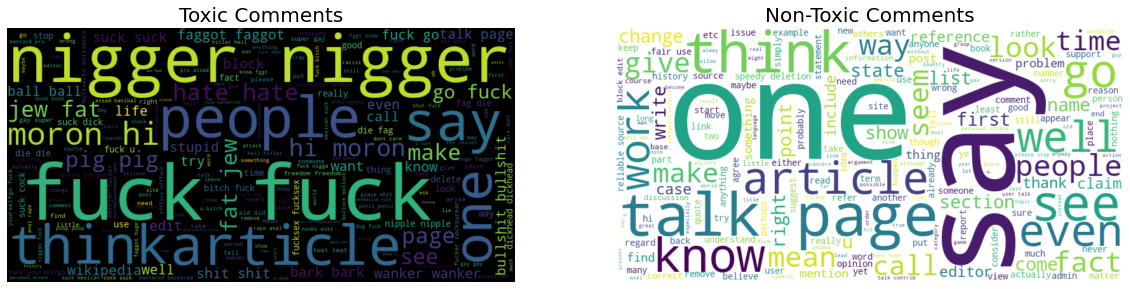

In [7]:
# Разделение на токсичные и нетоксичные
text_toxic = " ".join(df[df['toxic'] == 1]['text_clean'])
text_nontoxic = " ".join(df[df['toxic'] == 0]['text_clean'])

# Облака слов
wordcloud_toxic = WordCloud(width=800, height=400, background_color='black').generate(text_toxic)
wordcloud_nontoxic = WordCloud(width=800, height=400, background_color='white').generate(text_nontoxic)

# Визуализация
fig, axs = plt.subplots(1, 2, figsize=(20, 10))

axs[0].imshow(wordcloud_toxic, interpolation='bilinear')
axs[0].set_title('Toxic Comments', fontsize=20)
axs[0].axis('off')

axs[1].imshow(wordcloud_nontoxic, interpolation='bilinear')
axs[1].set_title('Non-Toxic Comments', fontsize=20)
axs[1].axis('off')

plt.show()

In [8]:
 # Создание мешка слов
nltk.download('stopwords')
# Загрузка стоп слов
stop_words = set(nltk_stopwords.words('english'))

[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


**Выводы**

Для реализации проекта были предоставлены данные, которые содержали текстовые комментарии на английском языке. Было выявлено, что часть записей включает знаки и слова, не несущие смысловой нагрузки. Так была проведена очистка и лемматизация текста. Также были визуализированы классы позитивных и негативных комментариев с помощью облака слов.

Проведённая предобработка позволила существенно сократить объём «шума» в данных и подготовить корпус к векторизации и последующего качественного обучения модели машинного обучения.

## Обучение

In [9]:
# Разделение данных
X = df['text_clean']
y = df['toxic']
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

In [10]:
# TF-IDF-векторайзер
tfidf = TfidfVectorizer(
    ngram_range=(1, 2),
    min_df=5,
    max_df=0.9,
    sublinear_tf=True,
    stop_words=stop_words
)

In [11]:
# Создаем пайплан для логистической регрессии
pipe_lr = Pipeline([
    ('tfidf', tfidf),
    ('clf', LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42))
])

# Пайплайн SVM
pipe_svm = Pipeline([
    ('tfidf', tfidf),
    ('clf', LinearSVC(class_weight='balanced', random_state=42))
])

In [12]:
# Подбор гиперпараметров
param_grid_lr = {
    'clf__penalty': ['l1', 'l2'],
    'clf__C': [0.1, 0.5, 1, 2, 5, 10],
    'clf__solver': ['liblinear']
}

param_grid_svm = {
    'clf__C': [0.1, 0.5, 1, 2, 5, 10]
}


In [13]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

# GridSearch
grid_lr  = GridSearchCV(pipe_lr,  param_grid_lr,  scoring='f1', cv=cv, n_jobs=-1, verbose=1)
grid_svm = GridSearchCV(pipe_svm, param_grid_svm, scoring='f1', cv=cv, n_jobs=-1, verbose=1)

# Обучение моделей
grid_lr.fit(X_train, y_train)
grid_svm.fit(X_train, y_train)

print(f"LogReg best CV-F1 = {grid_lr.best_score_:.3f} | params = {grid_lr.best_params_}")
print(f"SVM    best CV-F1 = {grid_svm.best_score_:.3f} | params = {grid_svm.best_params_}")

Fitting 5 folds for each of 12 candidates, totalling 60 fits
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/opt/conda/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/opt/conda/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/opt/conda/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/opt/conda/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/opt/conda/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("L

LogReg best CV-F1 = 0.769 | params = {'clf__C': 10, 'clf__penalty': 'l2', 'clf__solver': 'liblinear'}
SVM    best CV-F1 = 0.765 | params = {'clf__C': 0.5}


## Выводы

In [14]:
# Оценка модели LogReg на тестовой выборке
y_pred = grid_lr.predict(X_test)

print(f"F1 = {f1_score(y_test, y_pred):.3f}\n")
print(classification_report(y_test, y_pred, digits=3))

F1 = 0.774

              precision    recall  f1-score   support

           0      0.978     0.969     0.973     28622
           1      0.746     0.804     0.774      3237

    accuracy                          0.952     31859
   macro avg      0.862     0.886     0.873     31859
weighted avg      0.954     0.952     0.953     31859



Были выполнены следующие шаги для выполнения проекта по классификации комментариев на позитивные и негативные:
1. Загрузка, очистка и лемматизация текста 
2. Обучение двух моделей: Logistic Regression и LinearSVC
3. Применение TF-IDF и удаление стоп-слов

Обе модели показали результат F1 выше необходимого 0,75, но модель LogReg показала результат  немного лучше (F1 = 0.775).

Для улучшения качества модели можно использовать BERT.